In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime

In [216]:
# Import data
flu = pd.read_csv('../data/INFLUENZA_sentinella/data.csv')
weather = pd.read_csv('../data/weather/reg_weather.csv')
google_flu = pd.read_csv('../data/google_search_trend/reg_google_grippe.csv')
google_symptoms = pd.read_csv('../data/google_search_trend/reg_google_fieber_husten.csv')
pop = pd.read_csv('../data/pop_data_cantons/weekly_imputed_pop_data_final.csv')

<h3>Data Preparation</h3>

In [217]:
flu.columns

Index(['valueCategory', 'temporal', 'temporal_type', 'georegion',
       'georegion_type', 'agegroup', 'agegroup_type', 'sex', 'value',
       'popExtrapolation', 'totalConsultationsExtrapolation', 'incValue',
       'prctConsultations', 'prct', 'trend', 'dataComplete'],
      dtype='object')

In [218]:
# Create dataframe for country-level observations, no differentiation between sex or age
flu_CH = flu.query('georegion_type == "country" and agegroup == "all" and sex == "all"').copy()

# Create dataframe for regional observations, no differentiation between sex or age
flu_reg = flu.query('georegion_type == "sentinella_region" and agegroup == "all" and sex == "all"').copy()

# Drop unknown region entries from flu_region using mask
flu_reg = flu_reg[~(flu_reg['georegion'] == 'unknown')]

# Select columns required for analysis
selected_cols = ['temporal', 'georegion', 'popExtrapolation', 'incValue', 'value']
flu_reg = flu_reg[selected_cols]
flu_reg.rename(columns={'popExtrapolation':'flu_cases'}, inplace=True)

In [219]:
# Align time-indexes of google data and flu data
with open('date_dict.json', 'r') as f:
    date_dict = json.load(f)

google_flu['Woche'] = google_flu['Woche'].apply(lambda x: date_dict[x])
google_symptoms['Woche'] = google_symptoms['Woche'].apply(lambda x: date_dict[x])

In [220]:
dates = weather.date.values
# Convert dates to 'YYYY-Www' ISO week format
iso_week_dates = [datetime.strptime(date, '%Y-%m-%d').isocalendar()[:2] for date in dates]
iso_week_dates = [f'{year}-W{week:02d}' for year, week in iso_week_dates]
weather['date'] = iso_week_dates

In [221]:
# Reshape google_flu from wide to long
google_flu = google_flu.melt(id_vars=['Woche'], var_name='region_query', value_name='search_activity')

# Separate region and query information from header into separate rows
google_flu['region'] = google_flu['region_query'].apply(lambda x: "_".join(x.split('_')[:2]))
google_flu['query'] = google_flu['region_query'].apply(lambda x: "_".join(x.split('_')[2:]))
google_flu.drop(columns='region_query', inplace=True) # Drop superfluous region_query column

# Reshape dataframe to get separate columns for each variable
google_flu = google_flu.pivot(index=['Woche', 'region'], columns='query', values='search_activity').reset_index()

In [222]:
# Reshape google_flu from wide to long
google_symptoms = google_symptoms.melt(id_vars=['Woche'], var_name='region_query', value_name='search_activity')

# Separate region and query information from header into separate rows
google_symptoms['region'] = google_symptoms['region_query'].apply(lambda x: "_".join(x.split('_')[:2]))
google_symptoms['query'] = google_symptoms['region_query'].apply(lambda x: "_".join(x.split('_')[2:]))
google_symptoms.drop(columns='region_query', inplace=True) # Drop superfluous region_query column

# Reshape dataframe to get separate columns for each variable
google_symptoms = google_symptoms.pivot(index=['Woche', 'region'], columns='query', values='search_activity').reset_index()

In [223]:
merged_data = pd.merge(flu_reg, weather, how='left', left_on=['temporal', 'georegion'], right_on=['date', 'region']).sort_values(by=['georegion', 'temporal'])
merged_google = pd.merge(google_flu, google_symptoms, how='inner', on=['region', 'Woche'])
merged_data = pd.merge(merged_data, merged_google, how='left', left_on=['georegion', 'temporal'], right_on=['region', 'Woche'])

In [224]:
merged_data.columns

Index(['temporal', 'georegion', 'flu_cases', 'incValue', 'value', 'region_x',
       'date', 'weighted_avg_daily_temp', 'weighted_avg_daily_hum',
       'weighted_max_daily_temp', 'weighted_min_daily_temp',
       'weighted_max_daily_hum', 'weighted_min_daily_hum', 'Woche', 'region_y',
       'Flu', 'Flu_resid', 'Flu_seasonal', 'Flu_trend', 'Grippe',
       'Grippe_resid', 'Grippe_seasonal', 'Grippe_trend', 'Influenza',
       'Influenza_resid', 'Influenza_seasonal', 'Influenza_trend', 'influenza',
       'influenza_resid', 'influenza_seasonal', 'influenza_trend', 'Fieber',
       'Fieber_resid', 'Fieber_seasonal', 'Fieber_trend', 'fièvre',
       'fièvre_resid', 'fièvre_seasonal', 'fièvre_trend', 'husten',
       'husten_resid', 'husten_seasonal', 'husten_trend', 'toux', 'toux_resid',
       'toux_seasonal', 'toux_trend'],
      dtype='object')

In [225]:
merged_data.drop(columns=['region_x', 'region_y', 'date', 'Woche'], inplace=True)

In [226]:
import datetime

# Functions taken from: https://stackoverflow.com/questions/304256/whats-the-best-way-to-find-the-inverse-of-datetime-isocalendar
def iso_year_start(iso_year):
    "The gregorian calendar date of the first day of the given ISO year"
    fourth_jan = datetime.date(iso_year, 1, 4)
    delta = datetime.timedelta(fourth_jan.isoweekday()-1)
    return fourth_jan - delta 

def iso_to_gregorian(iso_year, iso_week, iso_day):
    "Gregorian calendar date for the given ISO year, week and day"
    year_start = iso_year_start(iso_year)
    return year_start + datetime.timedelta(days=iso_day-1, weeks=iso_week-1)


In [227]:
# Define the regex pattern
pattern = r'W(\d{1,2})'

# Extract week number and year and convert to integer
merged_data['week_number'] = merged_data['temporal'].str.extract(pattern).astype(int)

merged_data['year'] = merged_data['temporal'].apply(lambda x: x.split('-')[0])
merged_data['year'] = pd.to_numeric(merged_data['year'])

# Convert from iso-calendar week to dates
merged_data['date'] = list(map(lambda year, week: iso_to_gregorian(year, week, 4), merged_data['year'], merged_data['week_number']))

In [228]:
# merged_data.set_index('date', inplace=True)

In [229]:
# Impute missing values in March 2020 linearly
merged_data['incValue'].interpolate(inplace=True)

In [230]:
merged_data

temporal georegion  flu_cases  incValue   value  \
0     2013-W01  region_1    16876.1     53.33   918.5   
1     2013-W02  region_1    33045.6    114.99  1980.4   
2     2013-W03  region_1    37204.9    185.46  3194.0   
3     2013-W04  region_1    36421.1    307.51  5296.0   
4     2013-W05  region_1    39004.7    502.50  8654.2   
...        ...       ...        ...       ...     ...   
3403  2023-W42  region_6    14349.7     48.78   270.0   
3404  2023-W43  region_6    13789.4    116.03   642.3   
3405  2023-W44  region_6     9232.8     54.15   299.8   
3406  2023-W45  region_6    13692.8    131.46   727.7   
3407  2023-W46  region_6    12301.9    130.06   720.0   

      weighted_avg_daily_temp  weighted_avg_daily_hum  \
0                    3.044123               82.918337   
1                    1.899121               85.732108   
2                   -1.508554               77.031993   
3                   -0.759157               77.826791   
4                    4.551592               78.802057   
...                       ...                     ...   
3403                 8.779691               86.279860   
3404                 8.713151               90.941844   
3405                 5.359404               93.029671   
3406                 3.145168               86.804555   
3407                 4.537616               74.953285   

      weighted_max_daily_temp  weighted_min_daily_temp  \
0                    6.597668                -1.041057   
1                    4.005557                -0.232400   
2                    0.870462                -4.233867   
3                    2.469204                -4.891194   
4                    7.993836                 0.627968   
...                       ...                      ...   
3403               112.068950                15.165819   
3404               146.785800                14.580323   
3405               113.603722                11.504548   
3406               210.945316                10.245397   
3407               299.384319                12.711452   

      weighted_max_daily_hum  ...  husten_resid  husten_seasonal  \
0                  95.043840  ...           NaN              NaN   
1                  94.972297  ...     -6.176678         2.571313   
2                  90.875307  ...      3.287695        -2.697615   
3                  90.988158  ...      3.831175         4.759199   
4                  92.950733  ...     -6.717551         3.014675   
...                      ...  ...           ...              ...   
3403               16.738540  ...      7.342648        -4.320877   
3404               16.035777  ...     -0.478980        -5.410189   
3405               19.159654  ...      0.224958        -6.142114   
3406               16.910679  ...     -0.333561         1.301569   
3407               18.738479  ...    -29.735836        17.837256   

      husten_trend       toux  toux_resid  toux_seasonal  toux_trend  \
0              NaN        NaN         NaN            NaN         NaN   
1         7.329989  30.496017    2.831515      13.093592   14.570910   
2         7.387131  10.827069   -0.599317      -3.118453   14.544839   
3         7.443947  20.094055   -1.412146       6.987013   14.519188   
4         7.500430  11.163364   -1.808321      -1.522283   14.493968   
...            ...        ...         ...            ...         ...   
3403     11.786683   0.000000   -0.022954      -0.426565    0.449520   
3404     11.814702   0.000000   -0.171670      -0.269120    0.440791   
3405     11.842689  41.462083   41.346561      -0.316517    0.432039   
3406     11.870648   0.000000   -0.190492      -0.232774    0.423265   
3407     11.898580   0.000000   -0.036421      -0.378048    0.414469   

      week_number  year        date  
0               1  2013  2013-01-03  
1               2  2013  2013-01-10  
2               3  2013  2013-01-17  
3               4  2013  2013-01-24  
4               5  2013  2013-01-31  
...           ...   ...      

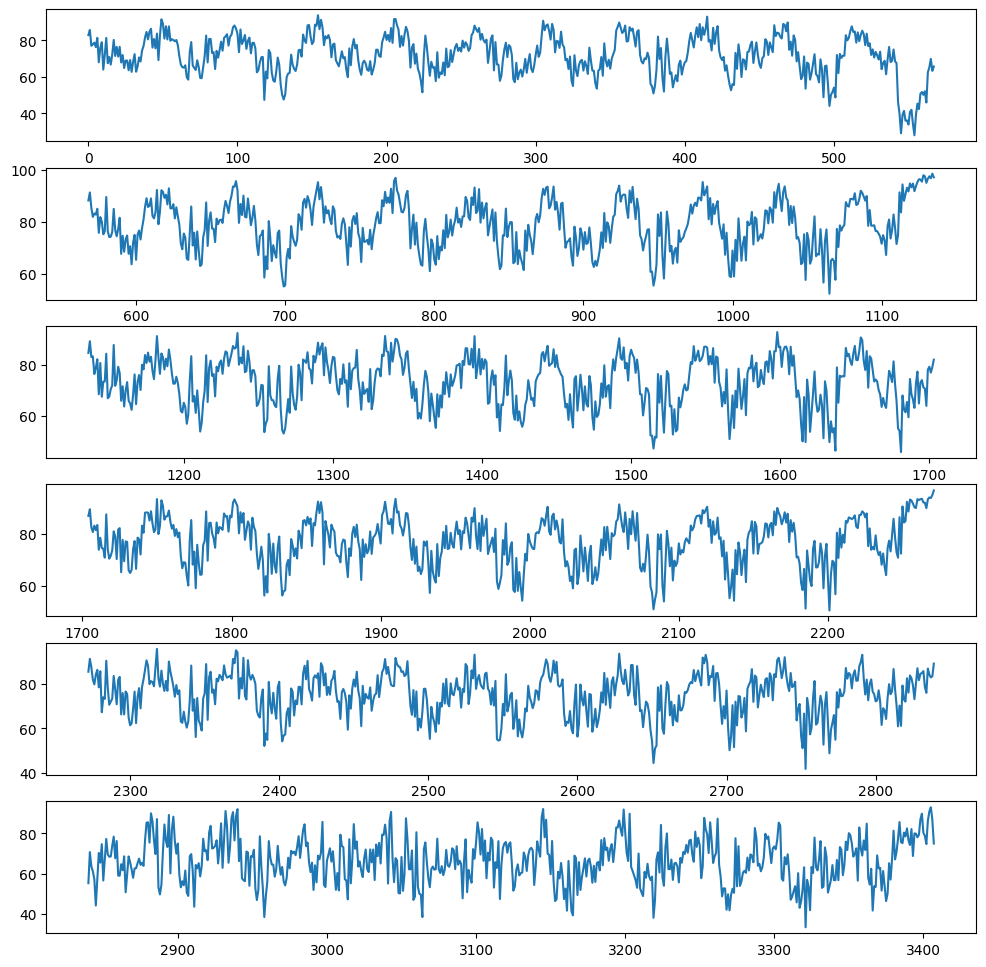

In [231]:
fig, ax = plt.subplots(6, figsize=(12, 12))
for i in range(1, 7):
    ax[i-1].plot(merged_data.loc[merged_data['georegion'] == f"region_{i}", 'weighted_avg_daily_hum'])

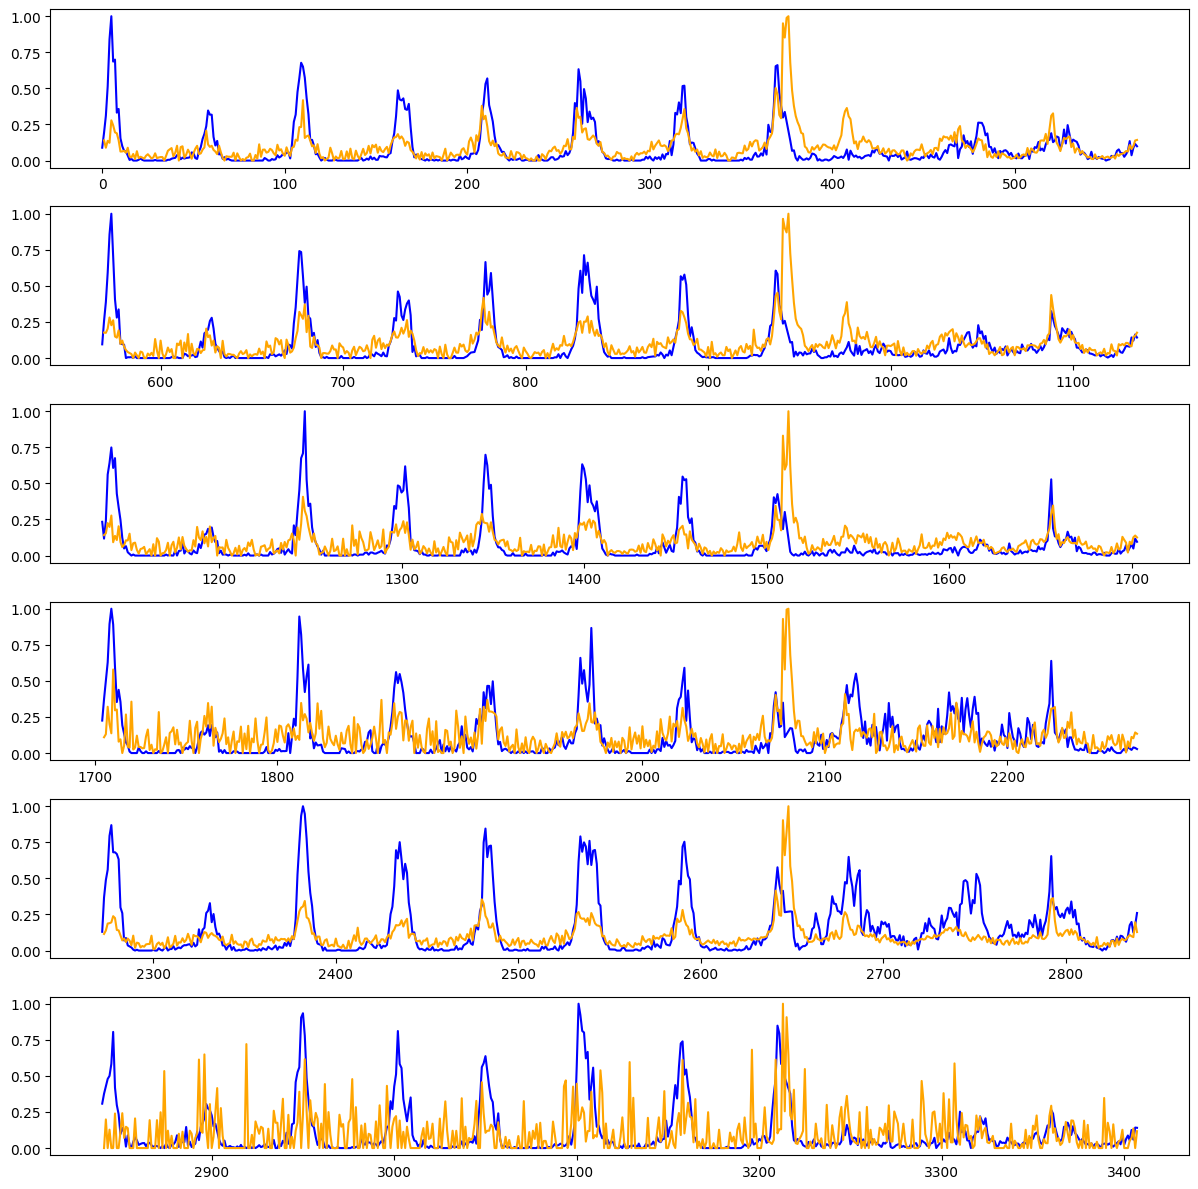

In [232]:
# fig, ax = plt.subplots(6, figsize=(12, 12))
# for i in range(1, 7):
#     ax[i-1].plot(merged_data.loc[merged_data['georegion'] == f"region_{i}", 'incValue'])
#     ax[i-1].plot(merged_data.loc[merged_data['georegion'] == f"region_{i}", 'Grippe'])

import matplotlib.pyplot as plt

# Assuming merged_data is your DataFrame and it's already been imported.

fig, ax = plt.subplots(6, figsize=(12, 12))

for i in range(1, 7):
    # Filter the data for the current region
    region_data = merged_data[merged_data['georegion'] == f"region_{i}"]
    
    # Find the maximum values for 'incValue' and 'Grippe' in the current region
    max_incValue_region = region_data['incValue'].max()
    max_Grippe_region = region_data['Grippe'].max()
    
    # Determine the scale factors
    scale_factor_incValue = 1.0 / max_incValue_region if max_incValue_region != 0 else 1
    scale_factor_Grippe = 1.0 / max_Grippe_region if max_Grippe_region != 0 else 1
    
    # Apply the scale factors to normalize the amplitude
    normalized_incValue = region_data['incValue'] * scale_factor_incValue
    normalized_Grippe = region_data['Grippe'] * scale_factor_Grippe
    
    # Plot the normalized data
    ax[i-1].plot(normalized_incValue, color='blue')
    ax[i-1].plot(normalized_Grippe, color='orange')
    
plt.tight_layout()
plt.show()



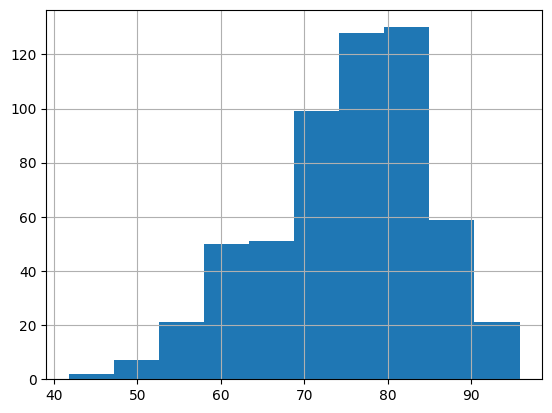

In [233]:
from matplotlib import pyplot
merged_data.loc[merged_data['georegion'] == "region_5", 'weighted_avg_daily_hum'].hist()
pyplot.show()

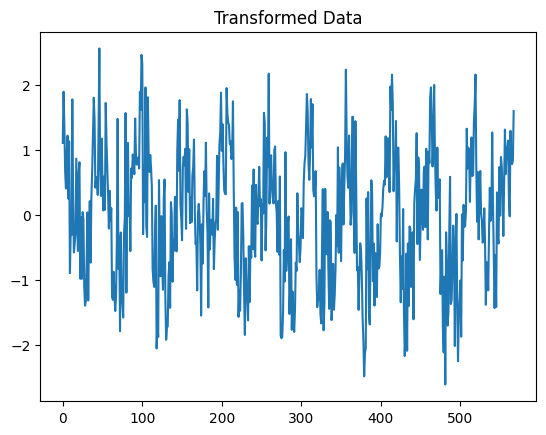

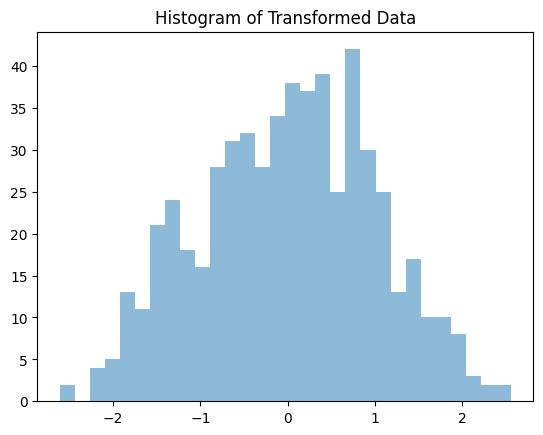

In [234]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer

# Assuming you have imported your dataset and stored it in merged_data

# Create the PowerTransformer with 'yeo-johnson' method
boxcox_transformer = PowerTransformer(method='yeo-johnson')

# Filter and select the data based on the 'georegion' condition and 'incValue' column
filtered_data = merged_data.loc[merged_data['georegion'] == "region_5", 'weighted_avg_daily_hum']

# Fit and transform the filtered data
transformed_data = boxcox_transformer.fit_transform(filtered_data.values.reshape(-1, 1))

# Create a figure and axis for the transformed data
fig1, ax1 = plt.subplots()
ax1.plot(transformed_data)
ax1.set_title('Transformed Data')

# Create a figure and axis for the histogram of transformed data
fig2, ax2 = plt.subplots()
ax2.hist(transformed_data, bins=30, alpha=0.5)
ax2.set_title('Histogram of Transformed Data')

# Show the plots
plt.show()


<h3>Modelling</h3>

In [235]:
def create_lagged_features(df, column, number_of_lags, seasonal_lags=None):
    # Copy the original DataFrame to avoid modifying it
    df_lagged = df.copy()

    # Generate regular lagged features
    for lag in range(1, number_of_lags + 1):
        df_lagged[f'lag_{lag}'] = df_lagged[column].shift(lag)

    # Generate seasonal lags
    if seasonal_lags is not None:
        for season_lag in seasonal_lags:
            df_lagged[f'seasonal_lag_{season_lag}_helper'] = df_lagged[column].shift(season_lag-1)
            df_lagged[f'seasonal_lag_{season_lag}'] = df_lagged[column].shift(season_lag)

    return df_lagged


In [236]:
import pandas as pd

def create_lagged_features(df, column_lags, seasonal_lags=None):
    """
    Create lagged features for multiple columns in a DataFrame, with a specified number of lags for each column.

    Parameters:
    df (DataFrame): The original DataFrame.
    columns_with_lags (dict): A dictionary mapping column names to the number of lags. e.g., {'column1': 3, 'column2': 5}
    seasonal_lags (list of int, optional): Additional seasonal lags to include.

    Returns:
    DataFrame: A DataFrame containing the original columns and their lagged features.
    """

    df_lagged = df.copy()
    seasonal_lags = seasonal_lags or []

    for column, num_lags in column_lags.items():
        # Create specified number of lagged features for each column
        for lag in range(1, num_lags + 1):
            df_lagged[f'{column}_lag_{lag}'] = df_lagged[column].shift(lag)

        # Create seasonal lagged features if specified
        for seasonal_lag in seasonal_lags:
            df_lagged[f'{column}_seasonal_lag_{seasonal_lag}_helper'] = df_lagged[column].shift(seasonal_lag-1)
            df_lagged[f'{column}_seasonal_lag_{seasonal_lag}'] = df_lagged[column].shift(seasonal_lag)

    return df_lagged


column_lags = {
    'incValue': 10,
    'Grippe': 5
    }



In [237]:
import numpy as np

def autoregressive_iterative_forecast(model, initial_input, seasonal_input, exogenous_forecasts, n_steps):
    """
    Perform iterative forecasting using an autoregressive model with multiple exogenous variable forecasts.

    Args:
        model: Trained autoregressive model (e.g., MLPRegressor).
        initial_input: The initial input features (e.g., the last observation from the training set).
        seasonal_input: Seasonal input features for the autoregressive model.
        exogenous_forecasts: List of arrays, each containing forecasted values for an exogenous variable.
        n_steps: Number of future time steps to forecast.

    Returns:
        A list of forecasts, one for each future time step.
    """
    i = 0
    current_input = np.array(initial_input.copy())
    seasonal_input = np.array(seasonal_input)
    forecasts = []

    for _ in range(n_steps):
        # Predict the next step
        next_step_pred = model.predict(current_input.reshape(1, -1))[0]
        forecasts.append(next_step_pred)

        # Update the current input to include the new prediction
        # Find the index where exogenous variables start
        exog_start_index = len(current_input) - len(seasonal_input) - sum(len(exog_forecast) for exog_forecast in exogenous_forecasts)
        
        # Roll all autoregressive lags
        current_input[:exog_start_index] = np.roll(current_input[:exog_start_index], 1)
        current_input[0] = next_step_pred
        
        # Update the seasonal lag (if applicable)
        seasonal_lag_index = exog_start_index + len(seasonal_input)
        if seasonal_input.size > 0:
            if i < len(seasonal_input):
                current_input[exog_start_index:seasonal_lag_index] = seasonal_input[i]
            else:
                current_input[exog_start_index:seasonal_lag_index] = forecasts[i - len(seasonal_input)]

        # Update the input with the forecasted exogenous variable values
        for j, exog_forecast in enumerate(exogenous_forecasts):
            current_input[seasonal_lag_index + j] = exog_forecast[i]

        i += 1

    return np.array(forecasts)


In [238]:
import numpy as np

def iterative_forecast(model, initial_input, seasonal_input,  n_steps, exogenous_forecasts=None):
    """
    Perform iterative forecasting using an autoregressive model with optional exogenous variable forecasts.

    Args:
        model: Trained autoregressive model (e.g., MLPRegressor).
        initial_input: The initial input features for the target variable (e.g., the last observation from the training set).
        seasonal_input: Seasonal input features for the target variable.
        exogenous_forecasts: (Optional) List or array containing the forecasted values for the exogenous variable(s) for each future time step.
        n_steps: Number of future time steps to forecast.

    Returns:
        A list of forecasts, one for each future time step.
    """
    forecasts = []
    current_input = np.array(initial_input)
    seasonal_input = np.array(seasonal_input)

    # Check if exogenous forecasts are provided
    if exogenous_forecasts is None:
        exogenous_forecasts = np.empty((n_steps, 0))  # Empty array with 0 columns

    for i in range(n_steps):
        # Prepare the input array for prediction
        combined_input = np.concatenate([
            current_input,
            exogenous_forecasts[i] if exogenous_forecasts.shape[1] > 0 else []  # Add the forecasted exogenous values if provided
        ])
        
        # Predict the next step
        next_step_pred = model.predict(combined_input.reshape(1, -1))[0]
        forecasts.append(next_step_pred)

        # Update the autoregressive lags for the target variable
        current_input = np.roll(current_input, 1)
        current_input[0] = next_step_pred
        
        # Update the seasonal lag, if applicable
        if i < 52:
            current_input[-1] = seasonal_input[i]
        else:
            current_input[-1] = forecasts[i - 52]

    return np.array(forecasts)


# # training_cols = [col for col in df_lagged.columns if ('lag_' in col) and ('_helper' not in col)]
# # X_train_cv_scaled = df_lagged[training_cols]
# # print(X_train_cv_scaled.iloc[0], f'Length:{len(X_train_cv_scaled.iloc[0])}')
# # print(df_lagged['seasonal_lag_52_helper'].iloc[:52])
# # prediction = autoregressive_iterative_forecast(model, X_train_cv_scaled.iloc[0], df_lagged[['seasonal_lag_52_helper']], 53)

In [239]:
def create_exogenous_input(model, initial_input, seasonal_input, n_steps):
    """
    Create a 2D array for exogenous variable inputs for each forecast step.

    Args:
        model: Model for exogenous variable to predict one week ahead.
        initial_input (array-like): The initial lag values for the exogenous variable.
        seasonal_input (array-like): Array of the values one week before the seasonal column for updating (essentially the lag_51 column, named 'seasonal_helper' in this notebook).
        n_steps (int): Number of future time steps to forecast.

    Returns:
        numpy.ndarray: A 2D array where each row represents all the lags and the seasonal lag for the exogenous variable for each week.
    """
    num_lags = len(initial_input)
    
    initial_input = np.array(initial_input)
    seasonal_input = np.array(seasonal_input)
    
    output_array = np.zeros((n_steps, num_lags))

    # Set initial lags and seasonal lag
    output_array[0, :] = initial_input

    forecasts = []
    for i in range(1, n_steps):
        # Predict the next step
        next_step_pred = model.predict(output_array[i-1,:].reshape(1, -1))[0]
        forecasts.append(next_step_pred)

        # Update lags: shift left and add new forecast
        output_array[i, :-1] = np.roll(output_array[i-1, :-1], 1) # Roll the consecutive autoregressive lags from one row before to shift weeks
        output_array[i, 0] = next_step_pred  # Insert most recent forecast in first position

        # Update seasonal lag
        if i < 52:
            output_array[i, -1] = seasonal_input[i-1]
        else:
            output_array[i, -1] = output_array[i-52, 0] # Fill in using the forecast from 52 weeks ago

    return output_array # Don't return the first column where value are all known to avoid shift

In [240]:
# Extract data
data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]
# Split the data
y = data['incValue']
split = int(len(y) * 0.8)
y_train, y_test = y[:split], y[split:]

i = 0
scores_df = pd.DataFrame(columns=['RMSE', 'lags', 'seasonal_lags', 'n_estimators', 'max_depth', 'min_samples_split'])

In [241]:
data

temporal georegion  flu_cases  incValue   value  \
2272  2013-W01  region_5    29374.0     51.07  1208.0   
2273  2013-W02  region_5    47752.8    144.49  3417.7   
2274  2013-W03  region_5    47406.5    191.96  4540.5   
2275  2013-W04  region_5    48168.7    220.06  5205.2   
2276  2013-W05  region_5    45494.3    312.13  7383.0   
...        ...       ...        ...       ...     ...   
2632  2019-W48  region_5    42994.2     25.58   645.7   
2633  2019-W49  region_5    42517.6     14.11   356.1   
2634  2019-W50  region_5    39607.8     30.30   764.8   
2635  2019-W51  region_5    43230.1     30.07   759.0   
2636  2019-W52  region_5    31438.3     34.99   883.2   

      weighted_avg_daily_temp  weighted_avg_daily_hum  \
2272                 3.593942               85.519447   
2273                 0.864670               91.314831   
2274                -3.802859               87.517543   
2275                -1.753243               82.001810   
2276                 4.443130               79.821785   
...                       ...                     ...   
2632                 5.348372               86.386609   
2633                 2.339055               80.471030   
2634                 3.917962               74.815746   
2635                 7.210735               76.655088   
2636                 3.133638               88.533667   

      weighted_max_daily_temp  weighted_min_daily_temp  \
2272                 5.390492                 1.231768   
2273                 2.839230                -0.715131   
2274                -1.860945                -5.470883   
2275                 0.721813                -4.374336   
2276                 7.421366                 1.815229   
...                       ...                      ...   
2632                 7.681465                 3.053613   
2633                 5.120918                -0.313293   
2634                 6.872819                 0.783974   
2635                10.703928                 4.057318   
2636                 5.048148                 1.334309   

      weighted_max_daily_hum  ...  husten_resid  husten_seasonal  \
2272               96.697391  ...           NaN              NaN   
2273               98.640572  ...      1.349902        12.662125   
2274               96.397491  ...     -1.983675        11.147623   
2275               96.887776  ...      1.414279         7.415400   
2276               93.992270  ...      0.749805        19.459827   
...                      ...  ...           ...              ...   
2632               97.037839  ...     -2.461691         5.143595   
2633               94.024797  ...     -0.982550         0.817679   
2634               92.433240  ...     -4.495523         7.489906   
2635               92.775643  ...     -1.451715        10.367312   
2636               97.228026  ...     -0.849980         9.843806   

      husten_trend       toux  toux_resid  toux_seasonal  toux_trend  \
2272           NaN        NaN         NaN            NaN         NaN   
2273     18.625146  15.939439   -9.808039       9.115253   16.632225   
2274     18.576824  27.927017    4.209686       6.977493   16.739838   
2275     18.528672  23.909158    2.591571       4.470200   16.847388   
2276     18.480697  43.833457   -3.285924      30.164497   16.954884   
...            ...        ...         ...            ...         ...   
2632     24.741441  13.551982    8.628772      -1.956498    6.879708   
2633     24.736377   0.000000   -3.820165      -3.011968    6.832133   
2634     24.731263  33.879956   33.894059      -6.800226    6.786123   
2635     24.726013  27.446706   26.587432      -5.882817    6.742090   
2636     24.720596  13.551982   -0.671631       7.523420    6.700194   

      week_number  year        date  
2272            1  2013  2013-01-03  
2273            2  2013  2013-01-10  
2274            3  2013  2013-01-17  
2275            4  2013  2013-01-24  
2276            5  2013  2013-01-31  
...           ...   ...      

In [242]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np

# Define parameter configurations to assess
lags = 52 # Autoregressive lags to consider
n_estimators = [100, 200] # Number of trees in the forest
max_depths = [10, 20, None] # Maximum depth of the trees
min_samples_splits = [2, 5] # Minimum number of samples required to split an internal node
seasonal = [52]

models_count = (lags-26) * len(n_estimators) * len(max_depths) * len(min_samples_splits)

# Extract data
data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]
# Split the data
y = data['incValue']
grippe = data['Grippe']
split = int(len(y) * 0.8)
y_train, y_test = y[:split], y[split:]
grippe_train, grippe_test = grippe[:split], grippe[split:]

i = 0
scores_df = pd.DataFrame(columns=['RMSE', 'lags', 'seasonal_lags', 'n_estimators', 'max_depth', 'min_samples_split'])

# Grid search hyperparameter configurations
for lag in range(20, lags-6):
    for n_estimator in n_estimators:
        for max_depth in max_depths:
            for min_samples_split in min_samples_splits:
                # Keep track of configurations and cv scores
                model = RandomForestRegressor(n_estimators=n_estimator, 
                                              max_depth=max_depth, 
                                              min_samples_split=min_samples_split, 
                                              random_state=42)

                grippe_model = RandomForestRegressor(n_estimators=100, 
                                     max_depth=20, 
                                     min_samples_split=2, 
                                     random_state=42)

                scores = []
                tscv = TimeSeriesSplit(n_splits=3, test_size=52)
                fold = 0

                column_lags = {
                    'incValue': lag,
                    'Grippe': 25
                }

                # Create lagged features based on the whole y_train
                df_lagged = create_lagged_features(pd.DataFrame({'incValue': y_train, 'Grippe': grippe_train}), column_lags=column_lags, seasonal_lags=[52])
                
                df_lagged.dropna(inplace=True)

                # Assign columns for preprocessing and training of autoregressive component
                flu_training_cols = [col for col in df_lagged.columns if ('incValue' in col) and ('lag' in col) and ('_helper' not in col)] # Select cols to include as features
                flu_seasonal_col = [col for col in df_lagged.columns if ('incValue' in col) and ('_helper' in col)] # Select cols to include as features
                X = df_lagged[flu_training_cols]
                X_seasonal = df_lagged[flu_seasonal_col]
                print(X, X_seasonal)
                y = df_lagged['incValue']

                # Assign columns for preprocessing and training of exogenous component
                grippe_training_cols = [col for col in df_lagged.columns if ('Grippe' in col) and ('lag' in col) and ('_helper' not in col)] # Select cols to include as features
                grippe_seasonal_col = [col for col in df_lagged.columns if ('Grippe' in col) and ('_helper' in col)] # Select cols to include as features
                grippe = df_lagged[grippe_training_cols]
                grippe_seasonal = df_lagged[grippe_seasonal_col]
                grippe_y = df_lagged['Grippe']

                for train_index, val_index in tscv.split(X):
                    y_train_cv, y_val = y.iloc[train_index], y.iloc[val_index]
                    X_train_cv, X_val = X.iloc[train_index], X.iloc[val_index]
                    X_seasonal_train, X_seasonal_val = X_seasonal.iloc[train_index], X_seasonal.iloc[val_index]

                    # Take the first row of X_train_cv (the oldest lags)
                    oldest_lags = X_train_cv.iloc[0, 1:].values.reshape(1, -1)

                    # Concatenate y_train_cv with the oldest lags
                    combined_data = np.vstack((y_train_cv.values.reshape(-1, 1), oldest_lags.T))

                    grippe_y_train_cv, grippe_y_val = grippe_y.iloc[train_index], grippe_y.iloc[val_index]
                    grippe_train_cv, grippe_val = grippe.iloc[train_index], grippe.iloc[val_index]
                    grippe_seasonal_train, grippe_seasonal_val = grippe_seasonal.iloc[train_index], grippe_seasonal.iloc[val_index]
                    # Take the first row of X_train_cv (the oldest lags)
                    oldest_grippe_lags = grippe_train_cv.iloc[0, 1:].values.reshape(1, -1)
                    # Concatenate grippe_y_train_cv with the oldest lags
                    grippe_combined_data = np.vstack((grippe_y_train_cv.values.reshape(-1, 1), oldest_grippe_lags.T))

                    grippe_model.fit(grippe_train_cv.values, grippe_y_train_cv)

                    grippe_input = create_exogenous_input(model=grippe_model, initial_input=grippe_val.iloc[0], seasonal_input=grippe_seasonal_val, n_steps=len(grippe_y_val))
                        
                    grippe_input_on_test = create_exogenous_input(model=grippe_model, initial_input=grippe_train_cv.iloc[0], seasonal_input=grippe_seasonal_train, n_steps=len(grippe_y_train_cv))

                    # Fit model
                    model.fit(X_train_cv, y_train_cv)
                    grippe_model.fit(X_train_cv, y_train_cv)

                    model.fit(np.concatenate((X_train_cv.values, grippe_train_cv.values), axis=1), y_train_cv)

                    prediction = iterative_forecast(model=model, initial_input=X_val.iloc[0], seasonal_input=X_seasonal_val, exogenous_forecasts=grippe_input, n_steps=len(y_val))

                    prediction = np.array(prediction).flatten()

                    # Calculate RMSE
                    rmse = mean_squared_error(y_val, prediction, squared=False)
                    scores.append(rmse)

                    fold += 1

                # Fill in parameters and score for each configuration 
                scores_df.loc[i, 'lags'] = lag
                scores_df.loc[i, 'seasonal_lags'] = seasonal
                scores_df.loc[i, 'n_estimators'] = n_estimator
                scores_df.loc[i, 'max_depth'] = max_depth
                scores_df.loc[i, 'min_samples_split'] = min_samples_split
                scores_df.loc[i, 'RMSE'] = np.mean(scores)
                print(f'{i}/{models_count}: {(i/models_count)*100:.2f}%')
                i += 1


      incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14.48           

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\U

0/312: 0.00%
      incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14.

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\U

1/312: 0.32%
      incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14.

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\U

2/312: 0.64%
      incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14.

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\U

3/312: 0.96%
      incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14.

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\U

4/312: 1.28%
      incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14.

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\U

5/312: 1.60%
      incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14.

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\U

6/312: 1.92%
      incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14.

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\U

7/312: 2.24%
      incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14.

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\U

8/312: 2.56%
      incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14.

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\U

9/312: 2.88%
      incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14.

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\U

10/312: 3.21%
      incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\U

11/312: 3.53%
      incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\U

12/312: 3.85%
      incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\U

13/312: 4.17%
      incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\U

14/312: 4.49%
      incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\U

15/312: 4.81%
      incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\U

16/312: 5.13%
      incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\U

17/312: 5.45%
      incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\U

18/312: 5.77%
      incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\U

19/312: 6.09%
      incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\U

20/312: 6.41%
      incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\U

21/312: 6.73%
      incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\U

22/312: 7.05%
      incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\184493995.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_array[i, -1] = seasonal_input[i-1]
C:\U

KeyboardInterrupt: 

In [ ]:
X_train_cv

incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2455            0.00            9.42            2.11            2.24   
2456            2.34            0.00            9.42            2.11   
2457            0.00            2.34            0.00            9.42   
2458            2.64            0.00            2.34            0.00   
2459            4.35            2.64            0.00            2.34   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14.48           14.63   
2326           10.39           17.34           16.45           14.48   
2327           21.32           10.39           17.34           16.45   
2328           11.28           21.32           10.39           17.34   
2329           15.57           11.28           21.32           10.39   
...              ...             ...             ...             ...   
2455            6.16            0.00            2.45            4.64   
2456            2.24            6.16            0.00            2.45   
2457            2.11            2.24            6.16            0.00   
2458            9.42            2.11            2.24            6.16   
2459            0.00            9.42            2.11            2.24   

      incValue_lag_9  incValue_lag_10  ...  incValue_lag_12  incValue_lag_13  \
2325           11.84             6.27  ...             5.83             2.62   
2326           14.63            11.84  ...             8.50             5.83   
2327           14.48            14.63  ...             6.27             8.50   
2328           16.45            14.48  ...            11.84             6.27   
2329           17.34            16.45  ...            14.63            11.84   
...              ...              ...  ...              ...              ...   
2455            3.28             8.39  ...            49.52            46.72   
2456            4.64             3.28  ...            23.75            49.52   
2457            2.45             4.64  ...             8.39            23.75   
2458            0.00             2.45  ...             3.28             8.39   
2459            6.16             0.00  ...             4.64             3.28   

      incValue_lag_14  incValue_lag_15  incValue_lag_16  incValue_lag_17  \
2325            11.95             4.20             4.03             0.00   
2326             2.62            11.95             4.20             4.03   
2327             5.83             2.62            11.95             4.20   
2328             8.50             5.83             2.62            11.95   
2329             6.27             8.50             5.83             2.62   
...               ...              ...              ...              ...   
2455            97.34           130.35           211.63           236.05   
2456            46.72            97.34           130.35           211.63   
2457            49.52            46.72            97.34           130.35   
2458            23.75            49.52            46.72            97.34   
2459             8.39            23.75            49.52            46.72   

      incValue_lag_18  incValue_lag_19  incValue_lag_20  \
2325             9.83             5.87             0.00   
2326             0.00             9.83             5.87   
2327             4.03             0.00             9.83   
2328             4.20             4.03             0.00   
2329            11.95             4.20             4.03   
...               ...              ...          

In [ ]:
scores_df['RMSE'] = pd.to_numeric(scores_df['RMSE'])
# Best parameters and score
best_config_index = scores_df['RMSE'].idxmin()  # This gets the index of the minimum RMSE
best_config = scores_df.loc[best_config_index]  # Use the index to access the row
best_score = best_config['RMSE']
print(f"Best parameters: {best_config}")
print(f"Best score (RMSE): {best_score}")

Best parameters: RMSE                 83.313942
lags                        37
seasonal_lags             [52]
n_estimators               200
max_depth                   10
min_samples_split            2
Name: 210, dtype: object
Best score (RMSE): 83.31394181842168


In [ ]:
scores_df.sort_values(by='RMSE').head(20)

RMSE lags seasonal_lags n_estimators max_depth min_samples_split
210  83.313942   37          [52]          200        10                 2
236  83.433441   39          [52]          200        20                 2
238  83.433441   39          [52]          200      None                 2
164  83.497394   33          [52]          200        20                 2
166  83.497394   33          [52]          200      None                 2
143  83.569047   31          [52]          200      None                 5
141  83.569047   31          [52]          200        20                 5
139  83.754981   31          [52]          200        10                 5
222  83.761025   38          [52]          200        10                 2
307  83.769083   45          [52]          200        10                 5
187  83.826749   35          [52]          200        10                 5
78   83.854958   26          [52]          200        10                 2
142  83.913234   31          [52]          200      None                 2
140  83.913234   31          [52]          200        20                 2
117  83.924437   29          [52]          200        20                 5
119  83.924437   29          [52]          200      None                 5
284  83.927616   43          [52]          200        20                 2
286  83.927616   43          [52]          200      None                 2
301  83.966755   45          [52]          100        10                 5
179  83.999504   34          [52]          200      None                 5

In [ ]:
best_config = scores_df.loc[222]

In [ ]:
best_lag = best_config.values[1]
best_seasonal_lag = best_config.values[2]
best_n_estimators = best_config.values[3]
best_max_depth = best_config.values[4]
best_min_samples_split = best_config.values[5]

In [ ]:
# Filter the DataFrame
data = merged_data.loc[
    (merged_data['georegion'] == "region_5") & 
    (merged_data['date'].apply(lambda x: (x.year < 2020))) & 
    (merged_data['date'].apply(lambda x: (x > datetime.datetime.strptime('2013-01-03', '%Y-%m-%d').date())))
]
# Split the data
y = data['incValue']
grippe_y = data['Grippe']

column_lags = {
                'incValue': best_lag,
                'Grippe': 17
                }
    
# Create lagged features based on the whole available training data
df_lagged = create_lagged_features(pd.DataFrame({'incValue': y, 'Grippe': grippe_y}), column_lags=column_lags, seasonal_lags=[52])

split = int(len(y) * 0.8)
# NOTE: SPLIT BEFORE DROPPING TO AVOID DATA LEAKAGE
df_lagged_train = df_lagged.iloc[:split]
df_lagged_train = df_lagged_train.dropna()
df_lagged_test = df_lagged.iloc[split:]

In [ ]:

grippe_training_cols = [col for col in df_lagged.columns if ('Grippe' in col) and ('lag' in col) and ('_helper' not in col)] # Select cols to include as features
grippe_train = df_lagged_train[grippe_training_cols]
grippe_y_train = df_lagged_train['Grippe']
grippe_test = df_lagged_test[grippe_training_cols]
grippe_y_test = df_lagged_test['Grippe']

# Columns required for rolling of seasonal lag in iterative autoregressive forecast
grippe_seasonal_col = [col for col in df_lagged.columns if ('Grippe' in col) and ('_helper' in col)] # Select cols to include as features
grippe_train_seasonal = df_lagged_train[grippe_seasonal_col]
grippe_test_seasonal = df_lagged_test[grippe_seasonal_col]

# Take the first row of X_train_cv (the oldest lags)
oldest_grippe_lags = grippe_train.iloc[0, 1:].values.reshape(1, -1)
# Concatenate grippe_y_train_cv with the oldest lags
grippe_combined_data = np.vstack((grippe_y_train.values.reshape(-1, 1), oldest_grippe_lags.T))

# Initialize configuration of MLPRegressor based on CV results from separate training
grippe_model = RandomForestRegressor(n_estimators=100, 
                                     max_depth=20, 
                                     min_samples_split=2, 
                                     random_state=42)

grippe_model.fit(grippe_train.values, grippe_y_train)

grippe_input = create_exogenous_input(model=grippe_model, initial_input=grippe_test.iloc[0], seasonal_input=grippe_test_seasonal, n_steps=len(grippe_y_test))
grippe_input_train = create_exogenous_input(model=grippe_model, initial_input=grippe_train.iloc[0], seasonal_input=grippe_train_seasonal, n_steps=len(grippe_y_train))

KeyError: "['Grippe_lag_18', 'Grippe_lag_19', 'Grippe_lag_20', 'Grippe_lag_21', 'Grippe_lag_22', 'Grippe_lag_23', 'Grippe_lag_24', 'Grippe_lag_25'] not in index"

In [ ]:
flu_training_cols = [col for col in df_lagged.columns if ('incValue' in col) and ('lag' in col) and ('_helper' not in col)] # Select cols to include as features
df_lagged_train[flu_training_cols]

incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2325           15.57           11.28           21.32           10.39   
2326           57.83           15.57           11.28           21.32   
2327           28.28           57.83           15.57           11.28   
2328           56.68           28.28           57.83           15.57   
2329           61.96           56.68           28.28           57.83   
...              ...             ...             ...             ...   
2559            7.07            7.39            0.00            0.00   
2560            0.00            7.07            7.39            0.00   
2561            0.00            0.00            7.07            7.39   
2562            0.00            0.00            0.00            7.07   
2563            0.00            0.00            0.00            0.00   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2325           17.34           16.45           14.48           14.63   
2326           10.39           17.34           16.45           14.48   
2327           21.32           10.39           17.34           16.45   
2328           11.28           21.32           10.39           17.34   
2329           15.57           11.28           21.32           10.39   
...              ...             ...             ...             ...   
2559            0.00            2.68            2.52            2.91   
2560            0.00            0.00            2.68            2.52   
2561            0.00            0.00            0.00            2.68   
2562            7.39            0.00            0.00            0.00   
2563            7.07            7.39            0.00            0.00   

      incValue_lag_9  incValue_lag_10  ...  incValue_lag_12  incValue_lag_13  \
2325           11.84             6.27  ...             5.83             2.62   
2326           14.63            11.84  ...             8.50             5.83   
2327           14.48            14.63  ...             6.27             8.50   
2328           16.45            14.48  ...            11.84             6.27   
2329           17.34            16.45  ...            14.63            11.84   
...              ...              ...  ...              ...              ...   
2559            3.14            16.33  ...            26.99            41.52   
2560            2.91             3.14  ...            16.73            26.99   
2561            2.52             2.91  ...            16.33            16.73   
2562            2.68             2.52  ...             3.14            16.33   
2563            0.00             2.68  ...             2.91             3.14   

      incValue_lag_14  incValue_lag_15  incValue_lag_16  incValue_lag_17  \
2325            11.95             4.20             4.03             0.00   
2326             2.62            11.95             4.20             4.03   
2327             5.83             2.62            11.95             4.20   
2328             8.50             5.83             2.62            11.95   
2329             6.27             8.50             5.83             2.62   
...               ...              ...              ...              ...   
2559           122.22           128.90           235.72           273.77   
2560            41.52           122.22           128.90           235.72   
2561            26.99            41.52           122.22           128.90   
2562            16.73            26.99            41.52           122.22   
2563            16.33            16.73            26.99            41.52   

      incValue_lag_18  incValue_lag_19  incValue_lag_20  \
2325             9.83             5.87             0.00   
2326             0.00             9.83             5.87   
2327             4.03             0.00             9.83   
2328             4.20             4.03             0.00   
2329            11.95             4.20             4.03   
...               ...              ...          

In [ ]:
df_lagged_test[flu_training_cols]

incValue_lag_1  incValue_lag_2  incValue_lag_3  incValue_lag_4  \
2564            0.00            0.00            0.00            0.00   
2565            2.71            0.00            0.00            0.00   
2566            2.63            2.71            0.00            0.00   
2567            0.00            2.63            2.71            0.00   
2568            0.00            0.00            2.63            2.71   
...              ...             ...             ...             ...   
2632           33.03           15.70           26.01           16.08   
2633           25.58           33.03           15.70           26.01   
2634           14.11           25.58           33.03           15.70   
2635           30.30           14.11           25.58           33.03   
2636           30.07           30.30           14.11           25.58   

      incValue_lag_5  incValue_lag_6  incValue_lag_7  incValue_lag_8  \
2564            0.00            7.07            7.39            0.00   
2565            0.00            0.00            7.07            7.39   
2566            0.00            0.00            0.00            7.07   
2567            0.00            0.00            0.00            0.00   
2568            0.00            0.00            0.00            0.00   
...              ...             ...             ...             ...   
2632            4.52            3.05           12.16            4.01   
2633           16.08            4.52            3.05           12.16   
2634           26.01           16.08            4.52            3.05   
2635           15.70           26.01           16.08            4.52   
2636           33.03           15.70           26.01           16.08   

      incValue_lag_9  incValue_lag_10  ...  incValue_lag_12  incValue_lag_13  \
2564            0.00             0.00  ...             2.52             2.91   
2565            0.00             0.00  ...             2.68             2.52   
2566            7.39             0.00  ...             0.00             2.68   
2567            7.07             7.39  ...             0.00             0.00   
2568            0.00             7.07  ...             0.00             0.00   
...              ...              ...  ...              ...              ...   
2632            2.15             0.00  ...             0.00             2.39   
2633            4.01             2.15  ...             2.56             0.00   
2634           12.16             4.01  ...             0.00             2.56   
2635            3.05            12.16  ...             2.15             0.00   
2636            4.52             3.05  ...             4.01             2.15   

      incValue_lag_14  incValue_lag_15  incValue_lag_16  incValue_lag_17  \
2564             3.14            16.33            16.73            26.99   
2565             2.91             3.14            16.33            16.73   
2566             2.52             2.91             3.14            16.33   
2567             2.68             2.52             2.91             3.14   
2568             0.00             2.68             2.52             2.91   
...               ...              ...              ...              ...   
2632             2.51             0.00             0.00             0.00   
2633             2.39             2.51             0.00             0.00   
2634             0.00             2.39             2.51             0.00   
2635             2.56             0.00             2.39             2.51   
2636             0.00             2.56             0.00             2.39   

      incValue_lag_18  incValue_lag_19  incValue_lag_20  \
2564            41.52           122.22           128.90   
2565            26.99            41.52           122.22   
2566            16.73            26.99            41.52   
2567            16.33            16.73            26.99   
2568             3.14            16.33            16.73   
...               ...              ...          

In [ ]:


# Extract training columns and output variable from dataframe
flu_training_cols = [col for col in df_lagged.columns if ('incValue' in col) and ('lag' in col) and ('_helper' not in col)] # Select cols to include as features
X_train = df_lagged_train[flu_training_cols]
y_train = df_lagged_train['incValue']
X_test = df_lagged_test[flu_training_cols]
y_test = df_lagged_test['incValue']

# Columns required for rolling of seasonal lag in iterative autoregressive forecast
flu_seasonal_col = [col for col in df_lagged.columns if ('incValue' in col) and ('_helper' in col)] # Select cols to include as features
X_train_seasonal = df_lagged_train[flu_seasonal_col]
X_test_seasonal = df_lagged_test[flu_seasonal_col]

# Create combined data to fit transform on all available historical lags in training set
oldest_lags = X_train.iloc[0, 1:].values.reshape(1, -1) # Take the first row of X_train (the oldest lags)
combined_data = np.vstack((y_train.values.reshape(-1, 1), oldest_lags.T)) # Concatenate y_train_cv with the oldest lags

# Initialize the final model configuration
final_model = RandomForestRegressor(n_estimators=best_n_estimators, 
                                    max_depth=best_max_depth, 
                                    min_samples_split=best_min_samples_split, 
                                    random_state=42)

# Train final model
final_model.fit(np.concatenate((X_train.values, grippe_train.values), axis=1), y_train)

# Forecast for the length of the test set
forecasts = iterative_forecast(model=final_model, initial_input=X_test.iloc[0], seasonal_input=X_test_seasonal, exogenous_forecasts=grippe_input, n_steps=len(y_test))
y_hat_train = iterative_forecast(model=final_model, initial_input=X_train.iloc[0], seasonal_input=X_train_seasonal, exogenous_forecasts=grippe_input_train, n_steps=len(y_train))

rmse = mean_squared_error(y_test, forecasts, squared=False)
print(rmse)

# Evaluate the forecasts against the actual y_test values
rmse = mean_squared_error(y_test, forecasts, squared=False)

print(f"The RMSE for the forecasts is: {rmse:.3f}")

C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\1785268257.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_input[-1] = seasonal_input[i]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\1785268257.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_input[-1] = seasonal_input[i]
C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\1785268257.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_input[-1] = seasonal_input[i]
C:\Users\finn

46.62424286646342
The RMSE for the forecasts is: 46.624


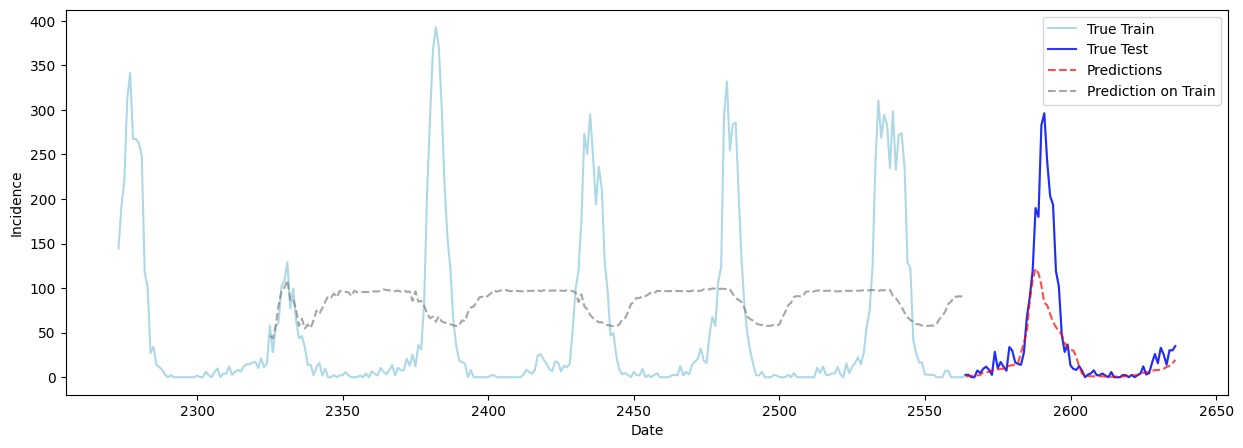

In [ ]:
# Plot the results
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the true values
# ax.plot(plot['incValue'])

ax.plot(df_lagged['incValue'], label="True Train", alpha=1, color='lightblue')
ax.plot(y_test.index, y_test, label="True Test", alpha=0.8, color='blue')
ax.plot(y_test.index, forecasts, label='Predictions', alpha=0.7, color='red', linestyle='--')
ax.plot(y_train.index, y_hat_train, label='Prediction on Train', alpha=0.7, color='grey', linestyle='--')


# Add labels and legend
ax.set_xlabel("Date")
ax.set_ylabel("Incidence")
ax.legend()

## Some trials with combining data

In [248]:
# start modelling here
pop_data = pd.read_csv('../data/pop_data_cantons/weekly_imputed_pop_data_final_region.csv')
flu_data = pd.read_csv('../data/INFLUENZA_sentinella/data.csv')
weather_data = pd.read_csv('../data/weather/reg_weather.csv')
google_flu_data = pd.read_csv('../data/google_search_trend/reg_google_grippe.csv')
google_symptoms_data = pd.read_csv('../data/google_search_trend/reg_google_fieber_husten.csv')

# Create dataframe for country-level observations, no differentiation between sex or age
flu_CH = flu_data.query('georegion_type == "country" and agegroup == "all" and sex == "all"').copy()

# Create dataframe for regional observations, no differentiation between sex or age
flu_reg = flu_data.query('georegion_type == "sentinella_region" and agegroup == "all" and sex == "all"').copy()

# Drop unknown region entries from flu_region using mask
flu_reg = flu_reg[~(flu_reg['georegion'] == 'unknown')]

# Select columns required for analysis
selected_cols = ['temporal', 'georegion', 'popExtrapolation', 'incValue']
flu_reg = flu_reg[selected_cols]
flu_reg.rename(columns={'popExtrapolation':'flu_cases'}, inplace=True)

# Align time-indexes of google data and flu data
with open('date_dict.json', 'r') as f:
    date_dict = json.load(f)

google_flu_data['Woche'] = google_flu_data['Woche'].apply(lambda x: date_dict[x])
google_symptoms_data['Woche'] = google_symptoms_data['Woche'].apply(lambda x: date_dict[x])

dates = weather_data.date.values
# Convert dates to 'YYYY-Www' ISO week format
iso_week_dates = [datetime.datetime.strptime(date, '%Y-%m-%d').isocalendar()[:2] for date in dates]
iso_week_dates = [f'{year}-W{week:02d}' for year, week in iso_week_dates]
weather_data['date'] = iso_week_dates

# Reshape google_flu from wide to long
google_flu_data = google_flu_data.melt(id_vars=['Woche'], var_name='region_query', value_name='search_activity')

# Separate region and query information from header into separate rows
google_flu_data['region'] = google_flu_data['region_query'].apply(lambda x: "_".join(x.split('_')[:2]))
google_flu_data['query'] = google_flu_data['region_query'].apply(lambda x: "_".join(x.split('_')[2:]))
google_flu_data.drop(columns='region_query', inplace=True) # Drop superfluous region_query column

# Reshape dataframe to get separate columns for each variable
google_flu_data = google_flu_data.pivot(index=['Woche', 'region'], columns='query', values='search_activity').reset_index()

# Reshape google_flu from wide to long
google_symptoms_data = google_symptoms_data.melt(id_vars=['Woche'], var_name='region_query', value_name='search_activity')

# Separate region and query information from header into separate rows
google_symptoms_data['region'] = google_symptoms_data['region_query'].apply(lambda x: "_".join(x.split('_')[:2]))
google_symptoms_data['query'] = google_symptoms_data['region_query'].apply(lambda x: "_".join(x.split('_')[2:]))
google_symptoms_data.drop(columns='region_query', inplace=True) # Drop superfluous region_query column

# Reshape dataframe to get separate columns for each variable
google_symptoms_data = google_symptoms_data.pivot(index=['Woche', 'region'], columns='query', values='search_activity').reset_index()

merged_data = pd.merge(flu_reg, weather_data, how='left', left_on=['temporal', 'georegion'], right_on=['date', 'region']).sort_values(by=['georegion', 'temporal'])
merged_google = pd.merge(google_flu_data, google_symptoms_data, how='inner', on=['region', 'Woche'])
merged_data = pd.merge(merged_data, merged_google, how='left', left_on=['georegion', 'temporal'], right_on=['region', 'Woche'])

merged_data = pd.merge(merged_data, pop_data, how='left', left_on=['georegion', 'temporal'], right_on=['region', 'Jahr-Woche'])
merged_data.drop(columns=['region_x', 'region_y', 'date', 'Woche_x', 'Woche_y', 'Jahr-Woche', 'Bevölkerung 31. Dezember'], inplace=True)


In [249]:
# nur region 5, da mergen wir die autoregressive daten drauf
merged_data = merged_data.loc[merged_data['georegion'] == "region_5"]
merged_data

temporal georegion  flu_cases  incValue  weighted_avg_daily_temp  \
2272  2013-W01  region_5    29374.0     51.07                 3.593942   
2273  2013-W02  region_5    47752.8    144.49                 0.864670   
2274  2013-W03  region_5    47406.5    191.96                -3.802859   
2275  2013-W04  region_5    48168.7    220.06                -1.753243   
2276  2013-W05  region_5    45494.3    312.13                 4.443130   
...        ...       ...        ...       ...                      ...   
2835  2023-W42  region_5    37721.9     68.93                 7.050161   
2836  2023-W43  region_5    50118.9     77.81                 8.132024   
2837  2023-W44  region_5    46728.6     49.22                 5.626782   
2838  2023-W45  region_5    44805.3     69.19                 3.754012   
2839  2023-W46  region_5    45003.1    102.22                 5.218186   

      weighted_avg_daily_hum  weighted_max_daily_temp  \
2272               85.519447                 5.390492   
2273               91.314831                 2.839230   
2274               87.517543                -1.860945   
2275               82.001810                 0.721813   
2276               79.821785                 7.421366   
...                      ...                      ...   
2835               86.939425               142.813059   
2836               84.196658               131.386292   
2837               82.951984                48.595582   
2838               83.411818               110.422789   
2839               89.191529                28.293101   

      weighted_min_daily_temp  weighted_max_daily_hum  weighted_min_daily_hum  \
2272                 1.231768               96.697391               70.232086   
2273                -0.715131               98.640572               76.791913   
2274                -5.470883               96.397491               78.173043   
2275                -4.374336               96.887776               64.148218   
2276                 1.815229               93.992270               59.684295   
...                       ...                     ...                     ...   
2835                13.637392               29.598338                1.629718   
2836                14.469814               29.752692                4.352397   
2837                10.456870               32.336568                5.102460   
2838                 9.601663               31.661582                4.775503   
2839                11.424049               36.321535               11.546415   

      ...  Städtischer Kernraum  Einflussgebiet Stadt  \
2272  ...             1632491.0              481448.0   
2273  ...             1632861.0              481558.0   
2274  ...             1633232.0              481668.0   
2275  ...             1633602.0              481778.0   
2276  ...             1633973.0              481888.0   
...   ...                   ...                   ...   
2835  ...                   NaN                   NaN   
2836  ...                   NaN                   NaN   
2837  ...                   NaN                   NaN   
2838  ...                   NaN                   NaN   
2839  ...                   NaN                   NaN   

      Ausserhalb des Einflusses städtischer Kerne  BIP in Millionen CHF  \
2272                                     224389.0          207504.98132   
2273                                     224438.0          207504.98132   
2274                                     224488.0          207504.98132   
2275                                     224537.0          207504.98132   
2276                                     224587.0          207504.98132   
...                                           ...                   ...   
2835                                          NaN                   NaN   
2836                                          NaN                   NaN   
2837                                          NaN                   NaN   
2838                    

In [250]:

import datetime

# Functions taken from: https://stackoverflow.com/questions/304256/whats-the-best-way-to-find-the-inverse-of-datetime-isocalendar
def iso_year_start(iso_year):
    "The gregorian calendar date of the first day of the given ISO year"
    fourth_jan = datetime.date(iso_year, 1, 4)
    delta = datetime.timedelta(fourth_jan.isoweekday()-1)
    return fourth_jan - delta 

def iso_to_gregorian(iso_year, iso_week, iso_day):
    "Gregorian calendar date for the given ISO year, week and day"
    year_start = iso_year_start(iso_year)
    return year_start + datetime.timedelta(days=iso_day-1, weeks=iso_week-1)


# lags um 52 wochen auf alle Spalten
exogenous_columns = [
    'weighted_avg_daily_temp', 'weighted_avg_daily_hum', 'weighted_max_daily_temp', 
    'weighted_min_daily_temp', 'weighted_max_daily_hum', 'weighted_min_daily_hum', 
    'Flu', 'Flu_resid', 'Flu_seasonal', 'Flu_trend', 'Grippe', 'Grippe_resid', 
    'Grippe_seasonal', 'Grippe_trend', 'Influenza', 'Influenza_resid', 'Influenza_seasonal', 
    'Influenza_trend', 'influenza', 'influenza_resid', 'influenza_seasonal', 'influenza_trend', 
    'Fieber', 'Fieber_resid', 'Fieber_seasonal', 'Fieber_trend', 'fièvre', 'fièvre_resid', 
    'fièvre_seasonal', 'fièvre_trend', 'husten', 'husten_resid', 'husten_seasonal', 'husten_trend', 
    'toux', 'toux_resid', 'toux_seasonal', 'toux_trend', 'Geburten', 
    'Todesfälle', 'Überschuss', 'Wanderungssaldo international 1', 'Wanderungssaldo interkantonal', 
    'total', '% over Year', 'Alter 0–19', 'Alter 20–64', 'Alter 65 und mehr', 
    'Mann', 'Frau', 'Schweizer', 'Ausländer ', 'Ledig', 'Verheiratet', 'Verwitwet', 'Geschieden', 
    'Unverheiratet', 'In eingetragener Partnerschaft', 'Aufgelöste Partnerschaft', 'Städtischer Kernraum', 
    'Einflussgebiet Stadt', 'Ausserhalb des Einflusses städtischer Kerne', 'BIP in Millionen CHF', 
    'BIP Growth Laufende Preise', 'BIP Growth Preise Vorjahr', 'BIP pro Kopf', 'Bevölkerung', 
    '% over week', 'Pop Density'
]

merged_data.drop(columns=['region'], inplace=True)
lagged_df = merged_data.copy()
# Anwenden des Lags
for column in exogenous_columns:
    lagged_df[column + '_lagged'] = lagged_df.groupby('georegion')[column].shift(52)
    lagged_df.drop(columns=column, inplace=True)

lagged_df['incValue'].interpolate(inplace=True)

lagged_df

temporal georegion  flu_cases  incValue  Bevölkerung 1. Januar  \
2272  2013-W01  region_5    29374.0     51.07              2338327.0   
2273  2013-W02  region_5    47752.8    144.49              2338327.0   
2274  2013-W03  region_5    47406.5    191.96              2338327.0   
2275  2013-W04  region_5    48168.7    220.06              2338327.0   
2276  2013-W05  region_5    45494.3    312.13              2338327.0   
...        ...       ...        ...       ...                    ...   
2835  2023-W42  region_5    37721.9     68.93                    NaN   
2836  2023-W43  region_5    50118.9     77.81                    NaN   
2837  2023-W44  region_5    46728.6     49.22                    NaN   
2838  2023-W45  region_5    44805.3     69.19                    NaN   
2839  2023-W46  region_5    45003.1    102.22                    NaN   

      Canton Size (km²)  weighted_avg_daily_temp_lagged  \
2272             6149.0                             NaN   
2273             6149.0                             NaN   
2274             6149.0                             NaN   
2275             6149.0                             NaN   
2276             6149.0                             NaN   
...                 ...                             ...   
2835                NaN                       14.241739   
2836                NaN                       14.315579   
2837                NaN                        9.163056   
2838                NaN                        8.142906   
2839                NaN                        7.426559   

      weighted_avg_daily_hum_lagged  weighted_max_daily_temp_lagged  \
2272                            NaN                             NaN   
2273                            NaN                             NaN   
2274                            NaN                             NaN   
2275                            NaN                             NaN   
2276                            NaN                             NaN   
...                             ...                             ...   
2835                      84.156863                       18.347875   
2836                      78.029948                       18.798882   
2837                      84.132143                       12.306360   
2838                      86.166082                       11.014111   
2839                      81.439495                       10.294136   

      weighted_min_daily_temp_lagged  ...  Städtischer Kernraum_lagged  \
2272                             NaN  ...                          NaN   
2273                             NaN  ...                          NaN   
2274                             NaN  ...                          NaN   
2275                             NaN  ...                          NaN   
2276                             NaN  ...                          NaN   
...                              ...  ...                          ...   
2835                       11.274609  ...                    1811937.0   
2836                       11.074063  ...                    1812311.0   
2837                        6.227006  ...                    1812688.0   
2838                        5.616396  ...                    1813063.0   
2839                        4.995080  ...                    1813438.0   

      Einflussgebiet Stadt_lagged  \
2272                          NaN   
2273                          NaN   
2274                          NaN   
2275                          NaN   
2276                          NaN   
...                           ...   
2835                     531294.0   
2836                     531402.0   
2837                     531509.0   
2838                     531616.0   
2839                     531724.0   

      Ausserhalb des Einflusses städtischer Kerne_lagged  \
2272                                                NaN    
2273                                                NaN    
2274                                                NaN    
2275 

In [251]:
flu_training_cols = [col for col in df_lagged.columns if ('incValue' in col) and ('lag' in col) and ('_helper' not in col)] # Select cols to include as features
df_lagged_train_subset  = df_lagged_train[flu_training_cols]
df_lagged_test_subset  = df_lagged_test[flu_training_cols]

# Columns required for rolling of seasonal lag in iterative autoregressive forecast
flu_seasonal_col = [col for col in df_lagged.columns if ('incValue' in col) and ('_helper' in col)] # Select cols to include as features
X_train_seasonal = df_lagged_train[flu_seasonal_col]
X_test_seasonal = df_lagged_test[flu_seasonal_col]

# Stellen Sie sicher, dass die Indizes von merged_data und df_lagged_train/test übereinstimmen oder kompatibel sind
# Anpassung des Indexes von df_lagged_train/test, falls erforderlich

# Kombinieren der DataFrames
# Für Trainingsdaten
combined_train_df = lagged_df.join(df_lagged_train_subset, how='outer')
# Für Testdaten
combined_test_df = lagged_df.join(df_lagged_test_subset, how='outer')

# Überprüfen der kombinierten DataFrames
print(combined_train_df.head())
print(combined_test_df.head())


      temporal georegion  flu_cases  incValue  Bevölkerung 1. Januar  \
2272  2013-W01  region_5    29374.0     51.07              2338327.0   
2273  2013-W02  region_5    47752.8    144.49              2338327.0   
2274  2013-W03  region_5    47406.5    191.96              2338327.0   
2275  2013-W04  region_5    48168.7    220.06              2338327.0   
2276  2013-W05  region_5    45494.3    312.13              2338327.0   

      Canton Size (km²)  weighted_avg_daily_temp_lagged  \
2272             6149.0                             NaN   
2273             6149.0                             NaN   
2274             6149.0                             NaN   
2275             6149.0                             NaN   
2276             6149.0                             NaN   

      weighted_avg_daily_hum_lagged  weighted_max_daily_temp_lagged  \
2272                            NaN                             NaN   
2273                            NaN                             NaN   

In [252]:
# Extrahieren der saisonalen Spalten aus df_lagged_train und df_lagged_test
flu_seasonal_col = [col for col in df_lagged_train.columns if 'incValue' in col and '_helper' in col]
df_lagged_train_seasonal = df_lagged_train[flu_seasonal_col]
df_lagged_test_seasonal = df_lagged_test[flu_seasonal_col]

# Kombinieren der DataFrames
# Stellen Sie sicher, dass die Indizes von merged_data und df_lagged_train/test übereinstimmen oder kompatibel sind

# Für Trainingsdaten
combined_train_df = combined_train_df.join(df_lagged_train_seasonal, how='outer')
# Für Testdaten
combined_test_df = combined_test_df.join(df_lagged_test_seasonal, how='outer')

# Überprüfen der kombinierten DataFrames
print(combined_train_df.head())
print(combined_test_df.head())


      temporal georegion  flu_cases  incValue  Bevölkerung 1. Januar  \
2272  2013-W01  region_5    29374.0     51.07              2338327.0   
2273  2013-W02  region_5    47752.8    144.49              2338327.0   
2274  2013-W03  region_5    47406.5    191.96              2338327.0   
2275  2013-W04  region_5    48168.7    220.06              2338327.0   
2276  2013-W05  region_5    45494.3    312.13              2338327.0   

      Canton Size (km²)  weighted_avg_daily_temp_lagged  \
2272             6149.0                             NaN   
2273             6149.0                             NaN   
2274             6149.0                             NaN   
2275             6149.0                             NaN   
2276             6149.0                             NaN   

      weighted_avg_daily_hum_lagged  weighted_max_daily_temp_lagged  \
2272                            NaN                             NaN   
2273                            NaN                             NaN   

In [253]:
grippe_training_cols = [col for col in df_lagged.columns if ('Grippe' in col) and ('lag' in col) and ('_helper' not in col)] # Select cols to include as features
grippe_train = df_lagged_train[grippe_training_cols]
grippe_test = df_lagged_test[grippe_training_cols]

# Für Trainingsdaten
combined_train_df = combined_train_df.join(grippe_train, how='left')
# Für Testdaten
combined_test_df = combined_test_df.join(grippe_test, how='left')

# Columns required for rolling of seasonal lag in iterative autoregressive forecast
grippe_seasonal_col = [col for col in df_lagged.columns if ('Grippe' in col) and ('_helper' in col)] # Select cols to include as features
grippe_train_seasonal = df_lagged_train[grippe_seasonal_col]
grippe_test_seasonal = df_lagged_test[grippe_seasonal_col]

# Für Trainingsdaten
combined_train_df = combined_train_df.join(grippe_train_seasonal, how='left')
# Für Testdaten
combined_test_df = combined_test_df.join(grippe_test_seasonal, how='left')

print(combined_train_df.head())
print(combined_test_df.head())

KeyError: "['Grippe_lag_18', 'Grippe_lag_19', 'Grippe_lag_20', 'Grippe_lag_21', 'Grippe_lag_22', 'Grippe_lag_23', 'Grippe_lag_24', 'Grippe_lag_25'] not in index"

In [254]:
# Define the regex pattern
pattern = r'W(\d{1,2})'

# Extract week number and year and convert to integer
combined_test_df['week_number'] = combined_test_df['temporal'].str.extract(pattern).astype(int)

combined_test_df['year'] = combined_test_df['temporal'].apply(lambda x: x.split('-')[0])
combined_test_df['year'] = pd.to_numeric(combined_test_df['year'])

# Convert from iso-calendar week to dates
combined_test_df['date'] = list(map(lambda year, week: iso_to_gregorian(year, week, 4), combined_test_df['year'], combined_test_df['week_number']))

panel_df = combined_test_df.set_index(['date', 'georegion'])

panel_df.sort_index(inplace=True)
panel_df['flu_cases_lagged'] = panel_df.groupby(level='georegion')['flu_cases'].shift(52)
panel_df

temporal  flu_cases  incValue  Bevölkerung 1. Januar  \
date       georegion                                                         
2013-01-03 region_5   2013-W01    29374.0     51.07              2338327.0   
2013-01-10 region_5   2013-W02    47752.8    144.49              2338327.0   
2013-01-17 region_5   2013-W03    47406.5    191.96              2338327.0   
2013-01-24 region_5   2013-W04    48168.7    220.06              2338327.0   
2013-01-31 region_5   2013-W05    45494.3    312.13              2338327.0   
...                        ...        ...       ...                    ...   
2023-10-19 region_5   2023-W42    37721.9     68.93                    NaN   
2023-10-26 region_5   2023-W43    50118.9     77.81                    NaN   
2023-11-02 region_5   2023-W44    46728.6     49.22                    NaN   
2023-11-09 region_5   2023-W45    44805.3     69.19                    NaN   
2023-11-16 region_5   2023-W46    45003.1    102.22                    NaN   

                      Canton Size (km²)  weighted_avg_daily_temp_lagged  \
date       georegion                                                      
2013-01-03 region_5              6149.0                             NaN   
2013-01-10 region_5              6149.0                             NaN   
2013-01-17 region_5              6149.0                             NaN   
2013-01-24 region_5              6149.0                             NaN   
2013-01-31 region_5              6149.0                             NaN   
...                                 ...                             ...   
2023-10-19 region_5                 NaN                       14.241739   
2023-10-26 region_5                 NaN                       14.315579   
2023-11-02 region_5                 NaN                        9.163056   
2023-11-09 region_5                 NaN                        8.142906   
2023-11-16 region_5                 NaN                        7.426559   

                      weighted_avg_daily_hum_lagged  \
date       georegion                                  
2013-01-03 region_5                             NaN   
2013-01-10 region_5                             NaN   
2013-01-17 region_5                             NaN   
2013-01-24 region_5                             NaN   
2013-01-31 region_5                             NaN   
...                                             ...   
2023-10-19 region_5                       84.156863   
2023-10-26 region_5                       78.029948   
2023-11-02 region_5                       84.132143   
2023-11-09 region_5                       86.166082   
2023-11-16 region_5                       81.439495   

                      weighted_max_daily_temp_lagged  \
date       georegion                                   
2013-01-03 region_5                              NaN   
2013-01-10 region_5                              NaN   
2013-01-17 region_5                              NaN   
2013-01-24 region_5                              NaN   
2013-01-31 region_5                              NaN   
...                                              ...   
2023-10-19 region_5                        18.347875   
2023-10-26 region_5                        18.798882   
2023-11-02 region_5                        12.306360   
2023-11-09 region_5                        11.014111   
2023-11-16 region_5                        10.294136   

                      weighted_min_daily_temp_lagged  \
date       georegion                                   
2013-01-03 region_5                              NaN   
2013-01-10 region_5                              NaN   
2013-01-17 region_5                              NaN   
2013-01-24 region_5                              NaN   
2013-01-31 region_5                              NaN   
...                                              ...   
2023-10-19 region_5                        11.274609   
2023-10-26 region_5                        11.074063   
2023-11-02 region_5       

In [255]:
limited_panel_df = panel_df.loc[pd.to_datetime(panel_df.index.get_level_values('date')) <= pd.Timestamp('2019-12-31')]
limited_panel_df

temporal  flu_cases  incValue  Bevölkerung 1. Januar  \
date       georegion                                                         
2013-01-03 region_5   2013-W01    29374.0     51.07              2338327.0   
2013-01-10 region_5   2013-W02    47752.8    144.49              2338327.0   
2013-01-17 region_5   2013-W03    47406.5    191.96              2338327.0   
2013-01-24 region_5   2013-W04    48168.7    220.06              2338327.0   
2013-01-31 region_5   2013-W05    45494.3    312.13              2338327.0   
...                        ...        ...       ...                    ...   
2019-11-28 region_5   2019-W48    42994.2     25.58              2498910.0   
2019-12-05 region_5   2019-W49    42517.6     14.11              2498910.0   
2019-12-12 region_5   2019-W50    39607.8     30.30              2498910.0   
2019-12-19 region_5   2019-W51    43230.1     30.07              2498910.0   
2019-12-26 region_5   2019-W52    31438.3     34.99              2498910.0   

                      Canton Size (km²)  weighted_avg_daily_temp_lagged  \
date       georegion                                                      
2013-01-03 region_5              6149.0                             NaN   
2013-01-10 region_5              6149.0                             NaN   
2013-01-17 region_5              6149.0                             NaN   
2013-01-24 region_5              6149.0                             NaN   
2013-01-31 region_5              6149.0                             NaN   
...                                 ...                             ...   
2019-11-28 region_5              6149.0                        3.765341   
2019-12-05 region_5              6149.0                        7.506409   
2019-12-12 region_5              6149.0                       -0.738685   
2019-12-19 region_5              6149.0                        4.599776   
2019-12-26 region_5              6149.0                        0.583974   

                      weighted_avg_daily_hum_lagged  \
date       georegion                                  
2013-01-03 region_5                             NaN   
2013-01-10 region_5                             NaN   
2013-01-17 region_5                             NaN   
2013-01-24 region_5                             NaN   
2013-01-31 region_5                             NaN   
...                                             ...   
2019-11-28 region_5                       89.051621   
2019-12-05 region_5                       83.071352   
2019-12-12 region_5                       80.952223   
2019-12-19 region_5                       84.232737   
2019-12-26 region_5                       90.517717   

                      weighted_max_daily_temp_lagged  \
date       georegion                                   
2013-01-03 region_5                              NaN   
2013-01-10 region_5                              NaN   
2013-01-17 region_5                              NaN   
2013-01-24 region_5                              NaN   
2013-01-31 region_5                              NaN   
...                                              ...   
2019-11-28 region_5                         5.471652   
2019-12-05 region_5                         9.848099   
2019-12-12 region_5                         1.314384   
2019-12-19 region_5                         6.841690   
2019-12-26 region_5                         3.261441   

                      weighted_min_daily_temp_lagged  \
date       georegion                                   
2013-01-03 region_5                              NaN   
2013-01-10 region_5                              NaN   
2013-01-17 region_5                              NaN   
2013-01-24 region_5                              NaN   
2013-01-31 region_5                              NaN   
...                                              ...   
2019-11-28 region_5                         1.939055   
2019-12-05 region_5                         5.127055   
2019-12-12 region_5       

Und jetzt RF

In [257]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

year_len = 52
limited_panel_df.sort_index(inplace=True)

# remove 2013 via index level
# Konvertieren des Datums-Index in Timestamps
limited_panel_df.index = limited_panel_df.index.set_levels([pd.to_datetime(limited_panel_df.index.levels[0]), limited_panel_df.index.levels[1]])

# Filtern der Daten nach dem 1. Januar 2014
limited_panel_df = limited_panel_df.loc[limited_panel_df.index.get_level_values('date') >= pd.Timestamp('2014-01-01')]

# Trainings- und Testdaten aufteilen
train_size = len(limited_panel_df) - year_len
train_data = limited_panel_df.iloc[:train_size]
test_data = limited_panel_df.iloc[train_size:]

X_train = train_data.drop(columns=['flu_cases', 'incValue', 'temporal', 'Bevölkerung 1. Januar', 'Canton Size (km²)']).values
y_train = train_data['incValue'].values

# Imputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

best_rmse = np.inf
best_model = None

# Parameter für die Gittersuche
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Initialisierung des RandomForestRegressor
rf = RandomForestRegressor(random_state=0)

# Gittersuche
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Training der Modelle
grid_search.fit(X_train_imputed, y_train)

# Beste Parameter
best_params = grid_search.best_params_
print(f"Beste Parameter: {best_params}")

# Beste Modell
best_model = grid_search.best_estimator_

# Verwenden des besten Modells, um Vorhersagen für 2019 zu treffen
X_test_2019 = test_data.drop(columns=['flu_cases', 'incValue', 'temporal', 'Bevölkerung 1. Januar', 'Canton Size (km²)']).values
y_test_2019 = test_data['incValue'].values
X_test_2019_imputed = imputer.transform(X_test_2019)

predictions_2019 = best_model.predict(X_test_2019_imputed)
rmse_2019 = np.sqrt(mean_squared_error(y_test_2019, predictions_2019))

print(f"RMSE für das Jahr 2019: {rmse_2019}")

# Erstellen eines DataFrame für Vorhersagen und tatsächliche Werte
predictions_df = pd.DataFrame({
    'Predicted': predictions_2019,
    'True': y_test_2019
}, index=test_data.index)

# Berechnen des RMSE für jede Region
# Angenommen, die Regionen sind in einem MultiIndex auf der Ebene 'georegion'
for region in test_data.index.get_level_values('georegion').unique():
    region_data = predictions_df.loc[predictions_df.index.get_level_values('georegion') == region]
    rmse_region = np.sqrt(mean_squared_error(region_data['True'], region_data['Predicted']))
    print(f"RMSE für {region}: {rmse_region}")



C:\Users\finnl\AppData\Local\Temp\ipykernel_43856\3416844448.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_panel_df.sort_index(inplace=True)


Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Beste Parameter: {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
RMSE für das Jahr 2019: 33.42148962055125
RMSE für region_5: 33.42148962055125


In [258]:
best_model

RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_leaf=4,
                      random_state=0)

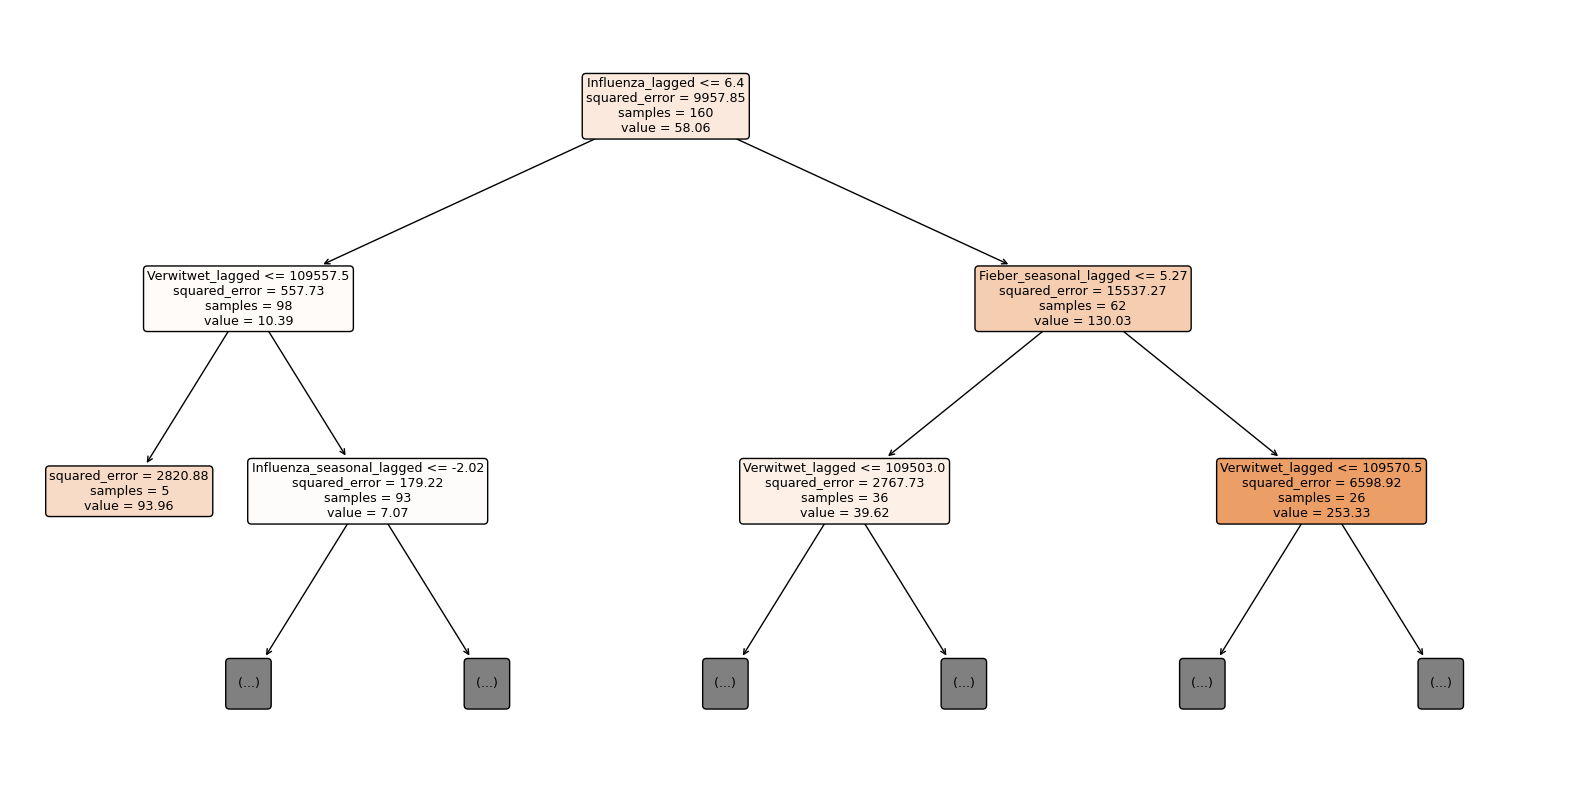

In [259]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Wählen Sie einen Baum aus dem Random Forest (z.B. den ersten Baum)
tree = best_model.estimators_[0]

# Visualisieren Sie den Baum
plt.figure(figsize=(20,10))
plot_tree(tree, 
          feature_names=train_data.columns.drop(['flu_cases', 'incValue', 'temporal', 'Bevölkerung 1. Januar', 'Canton Size (km²)']), 
          class_names=['Low', 'Medium', 'High'], 
          filled=True, 
          rounded=True, 
          precision=2,
          max_depth=2)
plt.show()


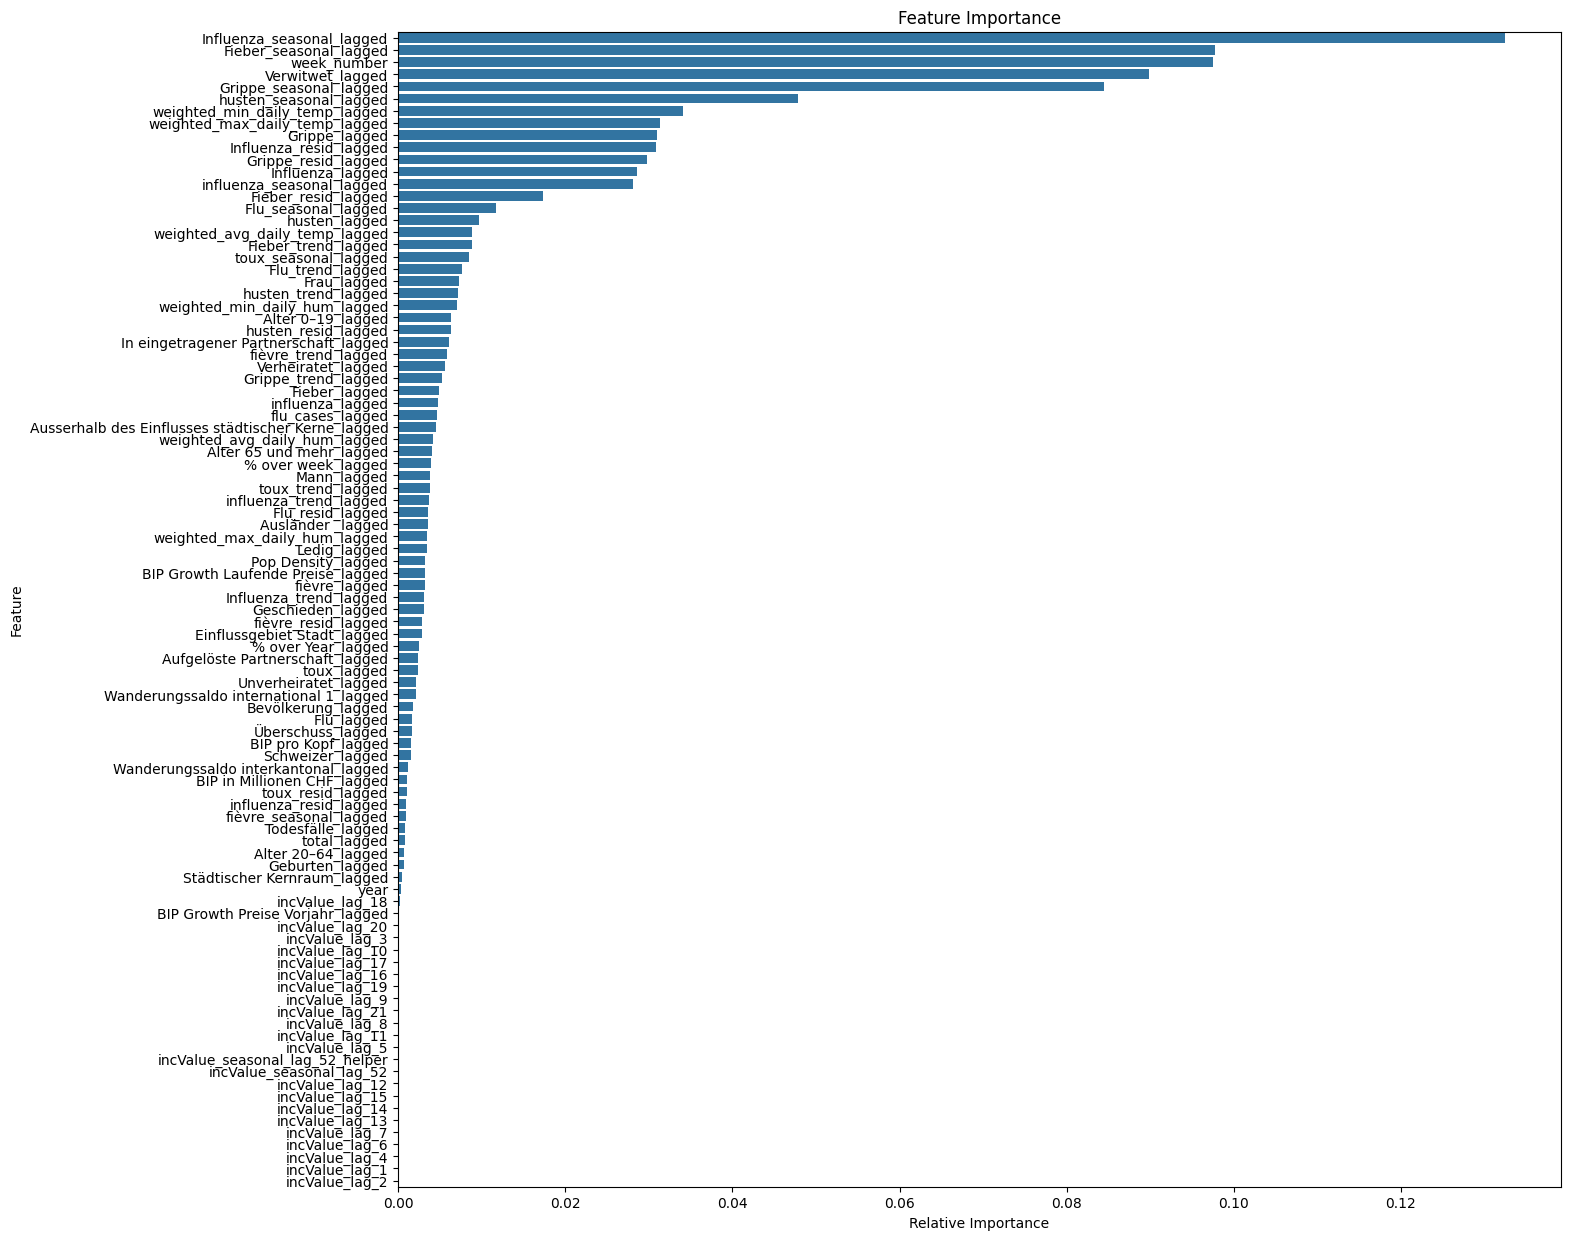

In [266]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature-Namen aus Ihrem Dataset extrahieren
feature_names = train_data.drop(columns=['flu_cases', 'incValue', 'temporal', 'Bevölkerung 1. Januar', 'Canton Size (km²)']).columns
# Feature Importance extrahieren
importances = best_model.feature_importances_

# Feature Importance in einem DataFrame speichern
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Feature Importance sortieren
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Erstellen des Plots
plt.figure(figsize=(15, 15))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')

# Plot anzeigen
plt.show()


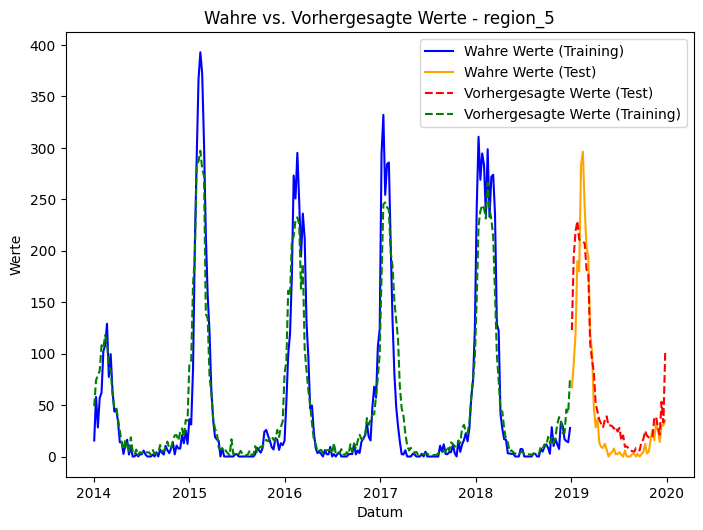

In [260]:
import matplotlib.pyplot as plt

X_train_index = limited_panel_df.index[:-year_len]
X_test_index = limited_panel_df.index[-year_len:]

# Verwenden von X_train_imputed für die Vorhersagen auf Trainingsdaten
train_predictions = best_model.predict(X_train_imputed)

# Der Rest des Codes bleibt gleich
train_predictions_df = pd.DataFrame(train_predictions, index=X_train_index, columns=['Predicted'])
test_predictions_df = pd.DataFrame(predictions_2019, index=X_test_index, columns=['Predicted'])

# Hinzufügen der wahren Werte zu den DataFrames
train_predictions_df['True'] = y_train
test_predictions_df['True'] = y_test_2019

# Kombinieren der Trainings- und Testdaten
combined_predictions_df = pd.concat([train_predictions_df, test_predictions_df])

# Reset des Index
combined_predictions_df_reset = combined_predictions_df.reset_index()

# Setzen der Plot-Größe
plt.figure(figsize=(20, 10))

# Reset des Index für Trainings- und Testdaten
train_predictions_df_reset = train_predictions_df.reset_index()
test_predictions_df_reset = test_predictions_df.reset_index()

# Erstellen von Unterplots für jede Region
unique_regions = combined_predictions_df_reset['georegion'].unique()
for i, region in enumerate(unique_regions, 1):
    plt.subplot(2, 3, i)  # 2 Reihen, 3 Spalten, aktueller Unterplot i

    # Filtern der Trainings- und Testdaten für die aktuelle Region
    train_region_data = train_predictions_df_reset[train_predictions_df_reset['georegion'] == region]
    test_region_data = test_predictions_df_reset[test_predictions_df_reset['georegion'] == region]

    plt.plot(train_region_data['date'], train_region_data['True'], color='blue', label='Wahre Werte (Training)')
    plt.plot(test_region_data['date'], test_region_data['True'], color='orange', label='Wahre Werte (Test)')
    plt.plot(test_region_data['date'], test_region_data['Predicted'], 'r--', label='Vorhergesagte Werte (Test)')
    plt.plot(train_region_data['date'], train_region_data['Predicted'], 'g--', label='Vorhergesagte Werte (Training)')

    plt.title(f'Wahre vs. Vorhergesagte Werte - {region}')
    plt.xlabel('Datum')
    plt.ylabel('Werte')
    plt.legend()

# Anzeigen des Gesamtplots
plt.tight_layout()  # Passt die Unterplots in den Plot-Bereich ein
plt.show()
